Josua Wahren: 4069111 (UdK)<br>
Daniel Fernandez: 395960 (TU)<br>
Richard Willy: 40688910 (UdK)<br>
Shu Matsunaga: 4070067 (UdK)

## 1. Import and display audio files

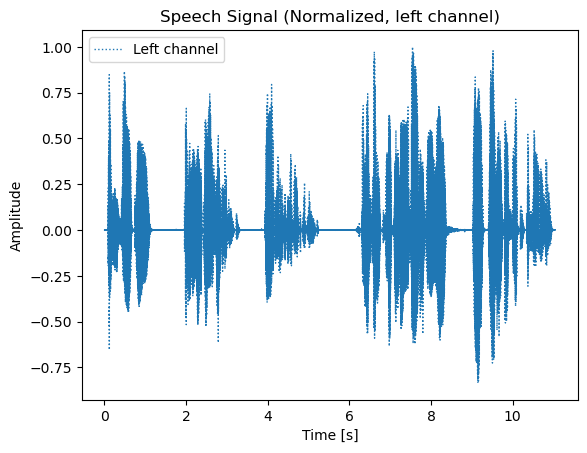

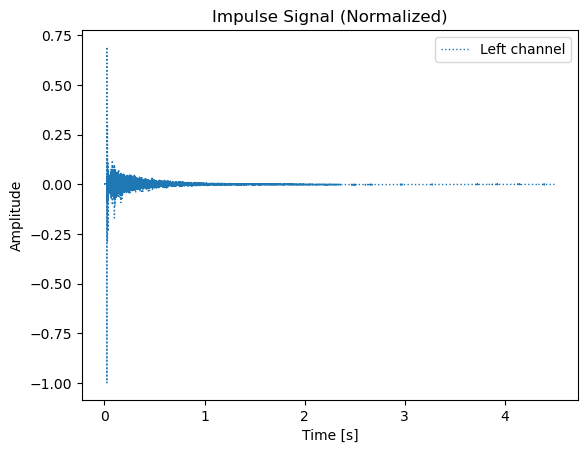

In [17]:
from pathlib import Path
import scipy as sp
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

path_folder = Path.cwd()
path_speech = path_folder / 'speech.wav' 
path_impuls = path_folder / 'impulse_response.wav'
x = sp.io.wavfile.read(path_speech)
h = sp.io.wavfile.read(path_impuls)
sr_x, data_x = sp.io.wavfile.read(path_speech)
sr_h, data_h = sp.io.wavfile.read(path_impuls)

length_x = data_x.shape[0] / sr_x
length_h = data_h.shape[0] / sr_h


time_x = np.linspace(0., length_x, data_x.shape[0])
max_amp_x = np.max(np.abs(data_x[:, 0])) # Normalize based on left channel
plt.plot(time_x, data_x[:, 0] / max_amp_x, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Speech Signal (Normalized, left channel)")
plt.show()

time_h = np.linspace(0., length_h, data_h.shape[0])
max_amp_h = np.max(np.abs(data_h)) # Normalize based on left channel
plt.plot(time_h, data_h / max_amp_h, label="Left channel",linestyle=':', linewidth=1)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Impulse Signal (Normalized)")
plt.show()

## 2. System properties

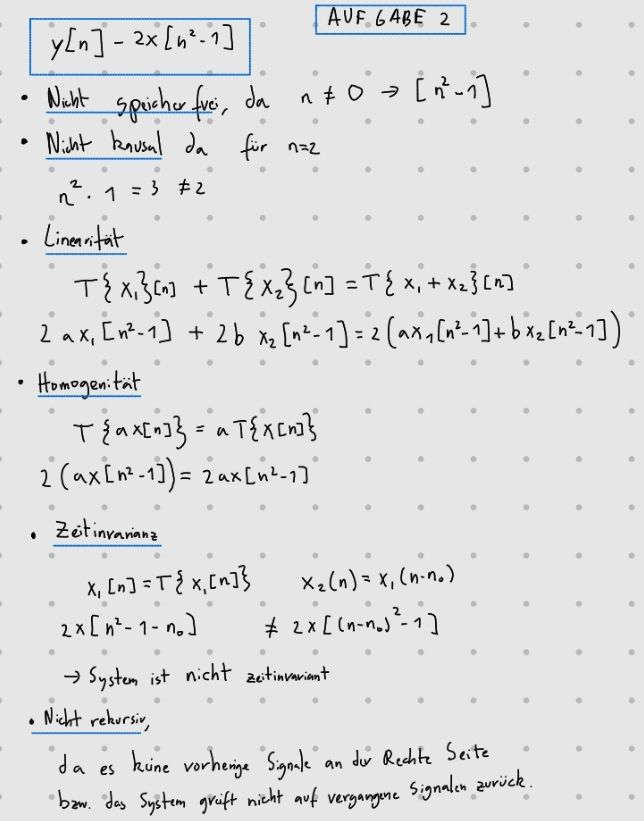

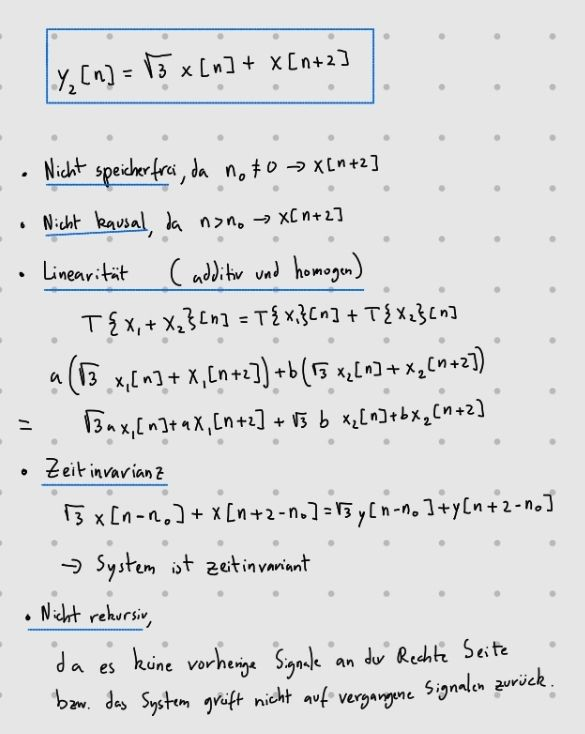

## 3. Convlution

### a)
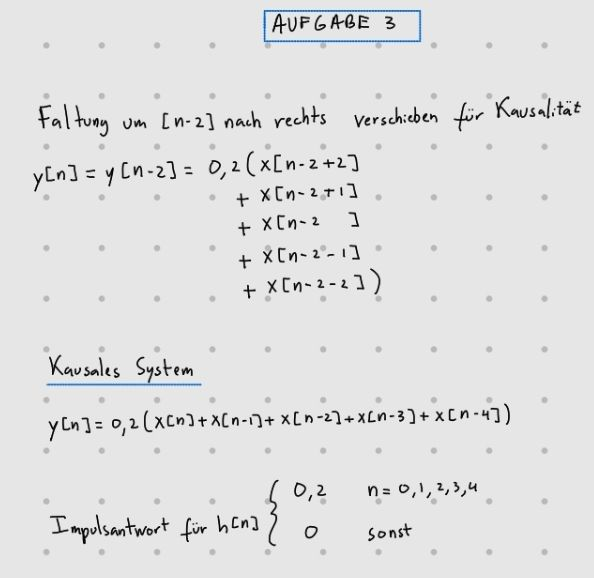

### b) 

In [21]:
def convolve(x, h):
    x_length = len(x)
    h_length = len(h)
    y = 0
    ausgangSignal = []
    for n in range(x_length + h_length - 1):
        y = 0
        for k in range(h_length):
            if 0 <= n -k < x_length:
                y += h[k]*x[n-k]
        ausgangSignal.append(y)
    return ausgangSignal

x = [1, -1]
h = [2, 0 ,0, 1]
print(convolve(x, h))



[2, -2, 0, 1, -1]


### c

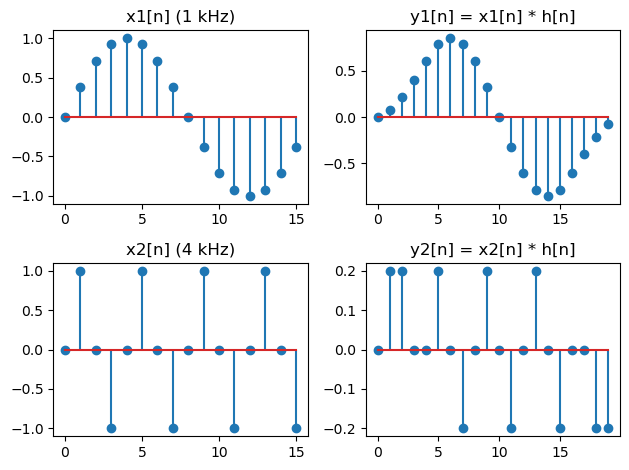

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fs = 16000          # sampling rate [Hz]
N = 16              # number of samples
n = np.arange(N)    # time index n = 0,1,...,15

f1 = 1000
f2 = 4000

# sine wave
x1 = np.sin(2 * np.pi * f1 * n / fs)  # 1 kHz
x2 = np.sin(2 * np.pi * f2 * n / fs)  # 4 kHz

# the impuls response from a)
h = [0.2, 0.2, 0.2, 0.2, 0.2]

# Convolution
y1 = convolve(x1, h)
y2 = convolve(x2, h)

n_y1 = np.arange(len(y1))  # time index for the convolved signals
n_y2 = np.arange(len(y2))

# Plot the results
plt.figure()

# x1 and y1
plt.subplot(2, 2, 1)
plt.stem(n, x1)
plt.title("x1[n] (1 kHz)")

plt.subplot(2, 2, 2)
plt.stem(n_y1, y1)
plt.title("y1[n] = x1[n] * h[n]")

# x2 and y2
plt.subplot(2, 2, 3)
plt.stem(n, x2)
plt.title("x2[n] (4 kHz)")

plt.subplot(2, 2, 4)
plt.stem(n_y2, y2)
plt.title("y2[n] = x2[n] * h[n]")

plt.tight_layout()
plt.show()



### d)
For y1[n] the increase of the value across the x axis is slowed down
 
For y2[n] the signal's amplitude is being reduced from 1 to 0.2

The values of the outgoing signal are the average of the 5 signals of the incoming signal which include the value at the same time and preceeding 4 samples. 
So, it's a 5-point moving average filter.
### e)


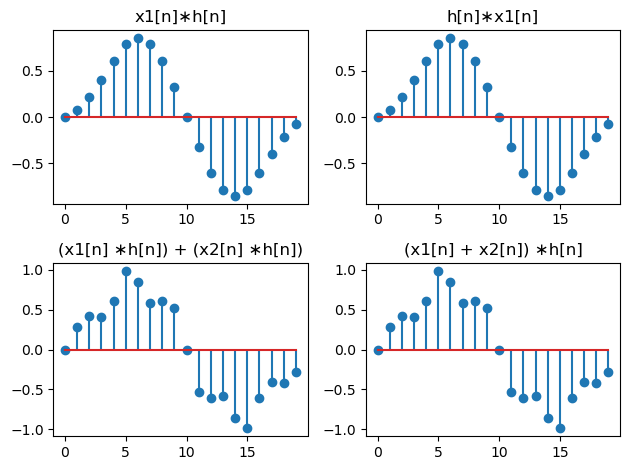

In [28]:
# Commutative property of convolution
L1 = convolve(x1, h)
R1 = convolve(h, x1)

# Distributive property of convolution
L2a = convolve(x1, h)
L2b = convolve(x2, h)
L2 = np.array(L2a) + np.array(L2b)
R2 = convolve(x1 + x2, h)

plt.subplot(2, 2, 1)
plt.stem(np.arange(len(L1)) , L1)
plt.title("x1[n]∗h[n]")

plt.subplot(2, 2, 2)
plt.stem(np.arange(len(R1)) , R1)
plt.title("h[n]∗x1[n]")

plt.subplot(2, 2, 3)
plt.stem(np.arange(len(L2)) , L2)
plt.title("(x1[n] ∗h[n]) + (x2[n] ∗h[n])")

plt.subplot(2, 2, 4)
plt.stem(np.arange(len(R2)), R2)
plt.title("(x1[n] + x2[n]) ∗h[n]")

plt.tight_layout()
plt.show()


## 4

In [55]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

def rdft(x, fs):
    N = len(x)
    X = np.zeros(N//2+1, dtype=complex)

    # Compute the single sided spectrum by DFT
    for k in range(N//2 + 1):
        for n in range(N):
            X[k] += x[n] * (np.cos(2 * np.pi * k * n / N) - 1j * np.sin(2 * np.pi * k * n / N))
    
    # Create frequency vector
    f = np.zeros(N//2 + 1)
    for m in range(N//2 + 1):
        f[m] = m * fs / N

    return X, f

# Comparison
fs = 44100
N = [1024, 1025, 1026, 1027, 4096, 8192]
for n in N:
    rng = np.random.default_rng(0) 
    white = rng.normal(loc=0.0, scale=1.0, size=n)
    X, f = rdft(white, fs)
    globals={"rdft": rdft, "x": white, "fs": fs, "np": np}
    np.testing.assert_allclose(X, np.fft.rfft(white))
    np.testing.assert_allclose(f, np.fft.rfftfreq(len(white), d=1./fs))
    print(timeit.timeit('rdft(x, fs)', number=5, globals=globals), "<- The computation time for ", n,"samples of the implemented function")
    print(timeit.timeit('np.fft.rfft(x)', number=5, globals=globals), "<- The computation time for", n,"samples of numpy.fft.rfft")
    print(timeit.timeit('np.fft.rfftfreq(len(x), d=1./fs)', number=5, globals=globals), "<- The computation time for", n,"samples of numpy.fft.rfftfreq")

38.15804589999607 <- The computation time for  1024 samples of the implemented function
0.0007737999985693023 <- The computation time for 1024 samples of numpy.fft.rfft
7.590001041535288e-05 <- The computation time for 1024 samples of numpy.fft.rfftfreq
38.08832790001179 <- The computation time for  1025 samples of the implemented function
0.0009513999975752085 <- The computation time for 1025 samples of numpy.fft.rfft
0.00016900000628083944 <- The computation time for 1025 samples of numpy.fft.rfftfreq
33.047070399989025 <- The computation time for  1026 samples of the implemented function
0.0007996000058483332 <- The computation time for 1026 samples of numpy.fft.rfft
0.00012749999586958438 <- The computation time for 1026 samples of numpy.fft.rfftfreq
33.027801499993075 <- The computation time for  1027 samples of the implemented function
0.0016751999937696382 <- The computation time for 1027 samples of numpy.fft.rfft
0.00012430000060703605 <- The computation time for 1027 samples o

## 5

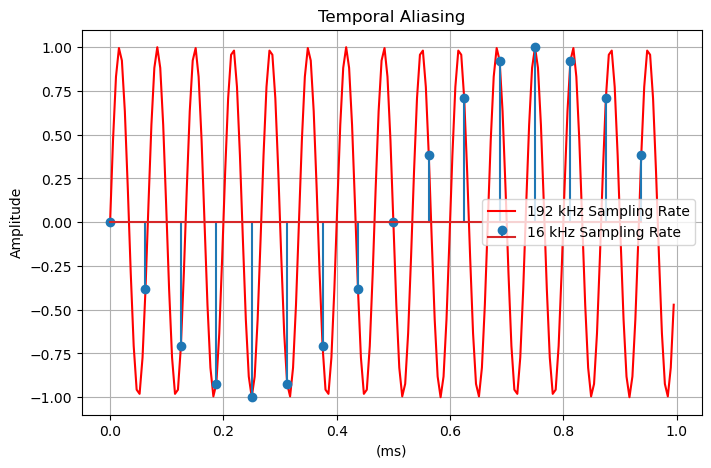

In [ ]:
 
import numpy as np
import matplotlib.pyplot as plt

# Constants
frequency = 15000  # 15 kHz

# High sampling rate (192 kHz)
sampling_rate_high = 192000  # 192 kHz
t_high = np.arange(0, 0.001, 1/sampling_rate_high)
signal_high = np.sin(2 * np.pi * frequency * t_high)

# Low sampling rate (16 kHz)
sampling_rate_low = 16000  # 16 kHz
t_low = np.arange(0, 0.001, 1/sampling_rate_low)
signal_low = np.sin(2 * np.pi * frequency * t_low)

plt.figure(figsize=(8, 5))
plt.plot(t_high * 1000, signal_high, color='red', label='192 kHz Sampling Rate')
plt.stem(t_low * 1000, signal_low, label='16 kHz Sampling Rate')
plt.grid(True)

plt.title('Temporal Aliasing')
plt.xlabel("(ms)")
plt.ylabel("Amplitude")
plt.legend()

plt.show()



According to Nyquist theorem, we need at least twice the sampling rate to sample a continuous signal without losing information.  
In this case, the lower sampling rate (16 kHz) does not fulfill this theorem, which is why between two samples of the lower sampling rates you can see a full cycle of the original sine signal (thanks to the high sampling rate of 192 kHz).